### **4. Customer segmentation**

In this section, we will segment our customers in order to guide our commercial activity. Knowing what the customers who belong to each group are like, will help us a lot when defining our marketing for the future. The phases we will work on include:

**4.1 Construction and last cleaning:** Creation of new features, creation of the df_last_partition that we will use for segmentation and last cleaning of the df.  
**4.2 Clustering using k-means:** Standardize the dataset, look for the optimal number of clusters and apply the k-means algorithm.    
**4.3 Cluster interpretation:**    
**4.4 Clients file:**    



Libraries:

In [2]:
# Data analysis and wrangling
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OrdinalEncoder,StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

# Machine learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics

Acquire data from the last notebook:

In [3]:
df = pd.read_csv('data2_easymoney.csv')

A small data type fix

In [4]:
df["pk_partition"]=pd.to_datetime(df["pk_partition"], format='%Y-%m-%d')
df["entry_date"]=pd.to_datetime(df["entry_date"], format='%Y-%m-%d')

#### **4.1 Construction and last cleaning**

##### **Creating new features**

Later we will create a df with only the data from the last month to make the Customer Segmentation.

However, keeping only the data from the last month has disadvantages, for example we are leaving a lot of information from past months unused. We will create some features that collect information about the previous months and in this way we can optimize the construction of the clusters.

* Registration time: time from registration to last partition
* Total registrations: total product registrations
* Total cancellations: total product cancellations
* Total revenues: Easymoney revenues from contracted products
* Average duration of products

**Registration time**  

Knowing how long the client has been discharged can provide us with useful information.  
Last date in the records are '2019-05-28'

In [5]:
df['loyalty'] = (pd.to_datetime('2019-05-28') - df['entry_date']).dt.days

**Total registrations and total cancellations**

We will calculate how manny times a customer has registered and unsubscribed for each product. Then will see the total registrations and total cancellations per customer.   

First of all we load the list of products from the Preprocessing section

In [6]:
prod_columns = ['short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_account']

We create a RegistrationsCancellations function, which will return us how many registrations and cancellations we have per customer and per product.

In [7]:
def RegistrationsCancellations(df, products):
    
    for i in products:
        previous_month = i + "_previous_month"
        difference = i + "_dif"
        dicc_reg = i + "_dicc_reg"
        dicc_canc = i + "_dicc_canc"
        registrations = i + "_registrations"
        cancellations = i + "_cancellations"
    
        #calculation of the contracted product for the previus month and the difference between both months.
        df[previous_month] = df.groupby('pk_cid')[i].shift(1)
        df[difference] = df[i] - df[previous_month]

        # REGISTRATIONS: creation of a diccionary in which -->
        # keys = pk_cid  ;  values = number of times difference is equal to 1
        dicc_reg = (df.loc[df[difference] == 1].groupby('pk_cid').size()).to_dict()
        df[registrations] = df['pk_cid'].map(dicc_reg).fillna(0).astype(int)
        
        # CANCELLATIONS: creation of a diccionary in which -->
        # keys = pk_cid  ;  values = number of times difference is equal to -1
        dicc_canc = (df.loc[df[difference] == -1].groupby('pk_cid').size()).to_dict()
        df[cancellations] = df['pk_cid'].map(dicc_canc).fillna(0).astype(int)

        #remove irrelevant columns
        df = df.drop([previous_month,difference], axis = 1)
        
        
    return df
    

In [8]:
df = RegistrationsCancellations(df, prod_columns)

Example: The client with 'pk_cid' == 1052217 we see that he has up to 4 registrations for the debit_card product and 3 cancellations. Let's see how the final df of these columns would look.

In [9]:
df.loc[df['pk_cid'] == 1052217, ['pk_partition', 'debit_card','debit_card_registrations', 'debit_card_cancellations'] ]

,pk_partition,debit_card,debit_card_registrations,debit_card_cancellations
884,2018-01-28,0,4,3
474283,2018-02-28,1,4,3
694896,2018-03-28,1,4,3
965738,2018-04-28,1,4,3
981599,2018-05-28,0,4,3
1257703,2018-06-28,0,4,3
1581909,2018-07-28,1,4,3
2046404,2018-08-28,0,4,3
2327229,2018-09-28,0,4,3
2672230,2018-10-28,1,4,3


Now we have everything necessary to calculate for each client how many total **Registrations and Cancellations** they have. We create a function, which will return us how many total registrations and total cancellations we have per customer.

In [10]:
def TotalRegistrationsCancellations(df):
    
    df['Registrations'] = df.filter(like='registration').sum(axis = 1)
    df['Cancellations'] = df.filter(like='cancellation').sum(axis = 1)
    
    return df

In [11]:
df = TotalRegistrationsCancellations(df)

In [12]:
df[['pk_cid','Registrations','Cancellations']].sample(10)

,pk_cid,Registrations,Cancellations
4415677,1405348,1,0
3508977,1325758,0,0
1691773,1254246,5,1
432318,1127454,0,1
3361485,1040202,0,0
755248,1262872,0,0
4232481,1301199,0,0
4939495,1121079,0,0
1540295,1186210,0,0
4523965,1019906,0,0


**Total revenues**

Easymoney gives us the following information about the income it receives from product registrations:  
* €10 for each account product sold
* €40 for each savings product sold
* €60 for each financing product sold   


First of all we load the list of the different products from the Preprocessing section

In [13]:
account_prod = ['payroll', 'payroll_account', 'emc_account', 'em_account_p', 'em_account', 
                'debit_card']
financing_prod = ['loans', 'mortgage', 'credit_card']
saving_prod = ['short_term_deposit', 'funds', 'securities', 'long_term_deposit',
               'pension_plan' ]

We create the feature revenue, multiplying each registration by its corresponding income, depending on what type of product it is:

In [14]:
df['total_revenue'] = df['payroll_registrations']*10 + df['payroll_account_registrations']*10 + df['emc_account_registrations']*10 + df['em_account_p_registrations']*10 + df['em_account_registrations']*10 + df['debit_card_registrations']*10 + df['loans_registrations']*60 + df['mortgage_registrations']*60 + df['credit_card_registrations']*60 + df['short_term_deposit_registrations']*40 + df['funds_registrations']*40 + df['securities_registrations']*40 + df['long_term_deposit_registrations']*40 + df['pension_plan_registrations']*40

We see how total_feature has values from 0 to 550 at most.
We also observe that the vast majority of clients have a 0 in this variable, that is, we can already see that there are many clients who have registered on the platform, but who have never contracted a product.

In [15]:
df['total_revenue'].unique()

array([ 20,   0,  50,  10,  40,  60,  70, 200, 130, 190, 110,  80, 160,
       120, 100,  90,  30, 150, 260, 230, 220, 140, 170, 330, 180, 210,
       240, 310, 280, 250, 290, 300, 270, 390, 410, 320, 380, 360, 370,
       420, 450, 400, 440, 340, 350, 430, 460, 550, 470, 500, 490])

In [16]:
df['total_revenue'].value_counts().head(10)

total_revenue
0      4704895
10      463407
20      156704
60       96041
40       72142
30       71543
50       67088
70       66577
80       36116
120      35947
Name: count, dtype: int64

**Average duration of products**

We want to calculate how much average time each customer has products in their portfolio.

To do this, we first calculate the mean of each product separately (df.groupby('pk_cid')[prod_columns].mean()). Here, for example, if the average 'em_account' is 0.5, it means that half of the time this customer has been registered on the platform he had this product contracted. Then we do the mean() again to find the total average of all products per customer.



In [17]:
average_customer = (df.groupby('pk_cid')[prod_columns].mean()).mean(axis=1)

In [18]:
df['average_time_products'] = df['pk_cid'].map(average_customer)

In [19]:
#sample of the new column
df[['pk_cid','average_time_products']].sample(10)

,pk_cid,average_time_products
4232484,1301196,0.071429
3220257,1284296,0.071429
4175305,1078047,0.071429
4452815,1441971,0.103175
4810388,1270816,0.071429
4291319,1244910,0.071429
3987599,1364042,0.071429
2335292,1056844,0.071429
4253966,1355090,0.071429
2358341,1154145,0.071429


Right now, we have the following **dataframe** with a total of **63 columns**

In [20]:
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(5962924, 63)


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_account,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,short_term_deposit_registrations,short_term_deposit_cancellations,loans_registrations,loans_cancellations,mortgage_registrations,mortgage_cancellations,funds_registrations,funds_cancellations,securities_registrations,securities_cancellations,long_term_deposit_registrations,long_term_deposit_cancellations,credit_card_registrations,credit_card_cancellations,payroll_registrations,payroll_cancellations,pension_plan_registrations,pension_plan_cancellations,payroll_account_registrations,payroll_account_cancellations,emc_account_registrations,emc_account_cancellations,debit_card_registrations,debit_card_cancellations,em_account_p_registrations,em_account_p_cancellations,em_account_registrations,em_account_cancellations,Registrations,Cancellations,total_revenue,average_time_products
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-12,6,1,2,1,29.0,0,35,0,87218.100000,1,1,0,0,501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,2,1,20,0.088235
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,2,0,1,1,13.0,1,23,0,35548.740000,1,1,0,0,1387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,2,0,1,1,13.0,1,23,0,122179.110000,1,1,0,0,1387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-08-10,6,0,1,1,50.0,0,22,0,119775.540000,1,0,0,1,1387,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.010204
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,2,1,1,1,50.0,1,23,0,119974.545133,1,1,0,0,1387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429


##### **Creating new df for the Customer Segmentation**

We will want to segment current customers, so we will use the data from the last month that we have in the registry. Additionally, when segmenting customers, we will only want customers who are currently alive, that is, deceased = 0.

In [21]:
#We see the partitions of the dataset
df['pk_partition'].unique()

<DatetimeArray>
['2018-01-28 00:00:00', '2018-02-28 00:00:00', '2018-03-28 00:00:00',
 '2018-04-28 00:00:00', '2018-05-28 00:00:00', '2018-06-28 00:00:00',
 '2018-07-28 00:00:00', '2018-08-28 00:00:00', '2018-09-28 00:00:00',
 '2018-10-28 00:00:00', '2018-11-28 00:00:00', '2018-12-28 00:00:00',
 '2019-01-28 00:00:00', '2019-02-28 00:00:00', '2019-03-28 00:00:00',
 '2019-04-28 00:00:00', '2019-05-28 00:00:00']
Length: 17, dtype: datetime64[ns]

In [22]:
#We see that we have 1075 dead clients
df['deceased'].value_counts()

deceased
0    5961849
1       1075
Name: count, dtype: int64

We create our dataframe, df_last_partition , with the last partition + live clients:

In [23]:
df_last_partition = df.loc[(df['pk_partition']== '2019-05-28') &(df['deceased']==0)]
print(df_last_partition.shape)
df_last_partition.head()

(442909, 63)


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_account,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,short_term_deposit_registrations,short_term_deposit_cancellations,loans_registrations,loans_cancellations,mortgage_registrations,mortgage_cancellations,funds_registrations,funds_cancellations,securities_registrations,securities_cancellations,long_term_deposit_registrations,long_term_deposit_cancellations,credit_card_registrations,credit_card_cancellations,payroll_registrations,payroll_cancellations,pension_plan_registrations,pension_plan_cancellations,payroll_account_registrations,payroll_account_cancellations,emc_account_registrations,emc_account_cancellations,debit_card_registrations,debit_card_cancellations,em_account_p_registrations,em_account_p_cancellations,em_account_registrations,em_account_cancellations,Registrations,Cancellations,total_revenue,average_time_products
5519929,657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-05-24,6,1,2,1,25.0,0,44,0,54493.380000,1,1,0,0,1465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429
5519930,657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-05-12,2,0,2,1,8.0,1,32,0,110949.866710,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
5519931,657986,2019-05-28,0,0,0,0,0,0,1,1,1,1,1,1,0,0,2016-02-18,6,1,2,1,41.0,0,39,0,100993.170000,6,4,1,1,1195,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,4,230,0.285714
5519932,657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017-02-07,0,1,3,1,28.0,0,85,0,154059.090000,2,1,0,1,840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.142857
5519933,657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-03-28,0,1,2,1,28.0,1,38,0,106793.037009,1,1,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,10,0.047619


##### **Last cleanning of df_last_partition**

At this point, we already have all the preprocessing done. But, if we have too many features doing the segmentation, the results we obtain aren't good.
So, in this section, we will have to reduce the dimensionality of our dataframe:

**Product features:** In notebook 2.Preprocessing, we have seen how the variables [credit_card, payroll, em_account_p, funds, loans, mortgage, securities, short_term_deposit] have very little variance and must be eliminated. Those are 8 of 14 product features. So, we will eliminate the 14, since we have created variables like [account_products, saving_products, finance_products, total_products] which already indicate the information related to the products.


In [24]:
df_last_partition = df_last_partition.drop(prod_columns, axis = 1)

**Irrelevant features:** 'pk_cid' is an irrelevant information for clustering customers. The 'pk_partition' feature does not provide any value, because in df_last_partition all the records belong to the last partition. The 'deceased' feature does not add value either, because we have only been left with the clients that are alive.

In [25]:
df_last_partition = df_last_partition.drop(['pk_cid','pk_partition', 'deceased'], axis = 1)

**High correlation:** Of course the feature 'entry_date' and 'loyalty' will have a correlation of -1 because are telling exactly the same. The feature 'loyalty' is more explicit so we will delete 'entry_date'.

In [26]:
df_last_partition = df_last_partition.drop('entry_date', axis = 1)

**Low variance:** country_id has so little variance, so we can eliminate it.  

In [27]:
df_last_partition = df_last_partition.drop(['country_id'], axis = 1)

**Registrations and Cancellations:** registrations and cancellations by product have very little variance. Furthermore, since we have total registrations and cancellations and we have to reduce the features for segmentation, we decided to eliminate registrations and cancellations for each product.

In [28]:
registrations_columns = [col for col in df_last_partition.columns if col.endswith('_registrations')]
cancellations_columns = [col for col in df_last_partition.columns if col.endswith('_cancellations')]

In [29]:
df_last_partition = df_last_partition.drop(registrations_columns, axis = 1)

In [30]:
df_last_partition = df_last_partition.drop(cancellations_columns, axis = 1)

**Final df_last_partition**

This is the df we will use in the next steps

In [31]:
print(df_last_partition.shape)
df_last_partition.reset_index(drop = True, inplace = True)
df_last_partition.head()

(442909, 16)


,entry_channel,active_customer,segment,region_code,gender,age,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,Registrations,Cancellations,total_revenue,average_time_products
0,6,1,2,25.0,0,44,54493.380000,1,1,0,0,1465,0,0,0,0.071429
1,2,0,2,8.0,1,32,110949.866710,0,0,0,0,16,0,0,0,0.000000
2,6,1,2,41.0,0,39,100993.170000,6,4,1,1,1195,5,4,230,0.285714
3,0,1,3,28.0,0,85,154059.090000,2,1,0,1,840,0,0,0,0.142857
4,0,1,2,28.0,1,38,106793.037009,1,1,0,0,61,1,0,10,0.047619


We see in the following correlation map how the only correlation > 0.95 is total_prod with account_prod. However, we think that the columns with the diferents types of products will be important to differentiate customers, so we will leave both variables.

<Axes: >

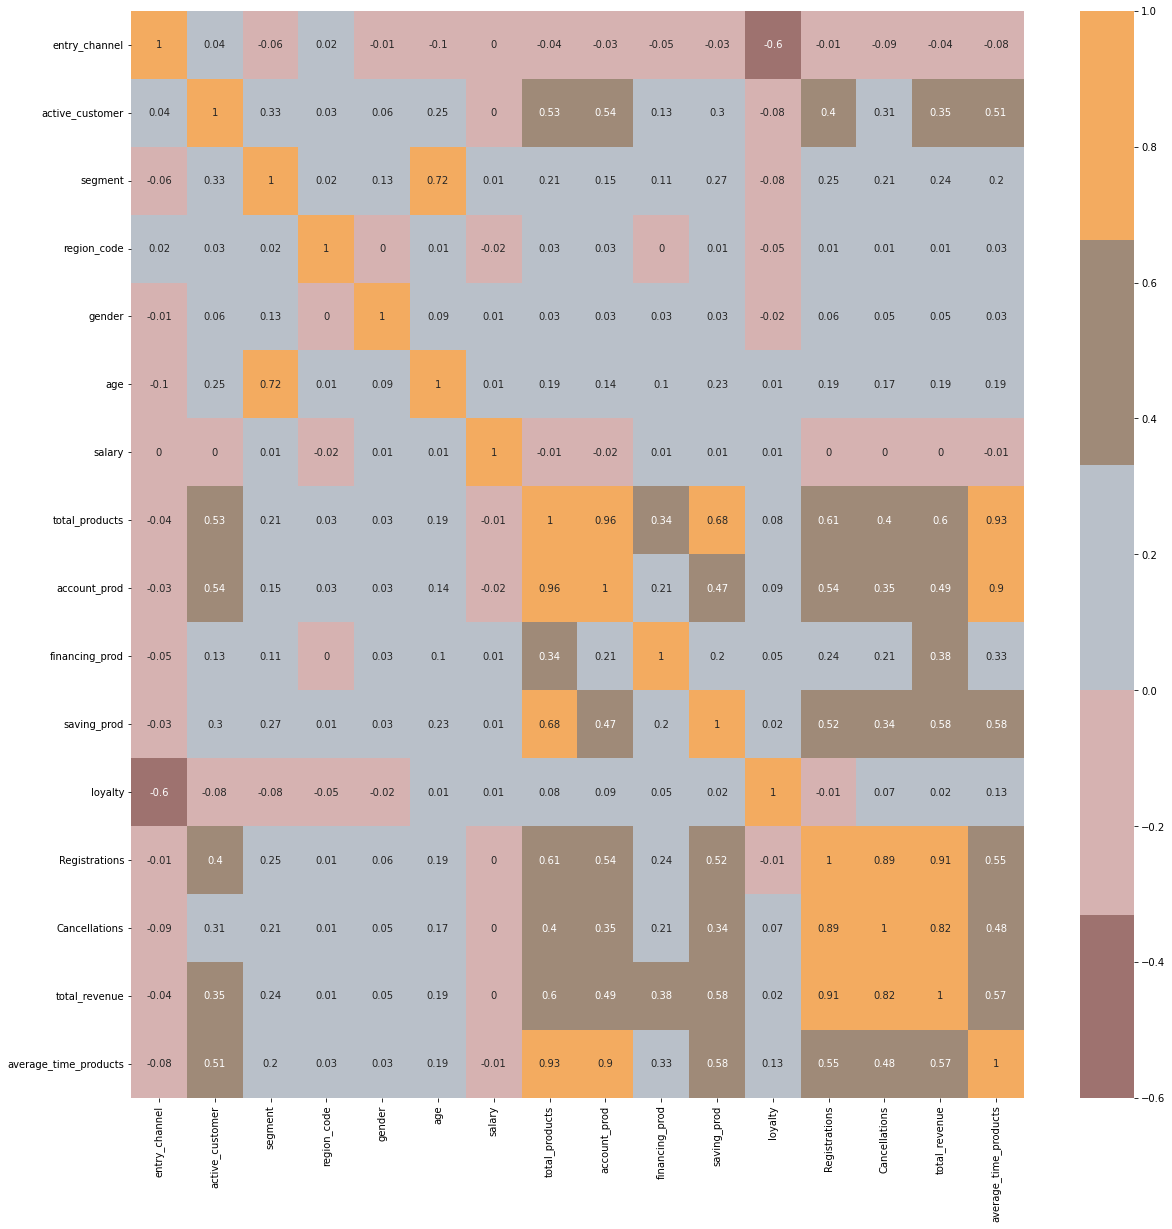

In [32]:
corrmat = df_last_partition.corr().round(2)
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

#### **4.2 Clustering using k-means**

##### **Standarize the dataset**

This initial step involve transforming the data. We will use the Standard scaler to have a mean of zero and a standard deviation of one across all features, ensuring uniformity and aiding convergence during clustering.

In [33]:
scaler = StandardScaler()

df_standard = scaler.fit_transform(df_last_partition)

df_standard = pd.DataFrame(df_standard, columns=df_last_partition.columns)

In [34]:
df_standard.head()

,entry_channel,active_customer,segment,region_code,gender,age,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,Registrations,Cancellations,total_revenue,average_time_products
0,1.868759,1.257915,1.228246,-0.065186,-0.972382,1.112850,-0.366418,0.010788,0.111341,-0.104765,-0.238541,1.678870,-0.379663,-0.340914,-0.314764,0.053118
1,-0.445479,-0.794967,1.228246,-1.321360,1.028402,0.131335,-0.032210,-1.097832,-1.268494,-0.104765,-0.238541,-1.663791,-0.379663,-0.340914,-0.314764,-1.206874
2,1.868759,1.257915,1.228246,1.117096,-0.972382,0.703886,-0.091151,5.553891,4.250845,9.454612,3.737071,1.056014,3.161125,2.891982,7.187811,3.833094
3,-1.602598,1.257915,3.170324,0.156492,-0.972382,4.466360,0.222985,1.119409,0.111341,-0.104765,3.737071,0.237073,-0.379663,-0.340914,-0.314764,1.313110
4,-1.602598,1.257915,1.228246,0.156492,1.028402,0.622093,-0.056818,0.010788,0.111341,-0.104765,-0.238541,-1.559982,0.328494,-0.340914,0.011435,-0.366879


##### **Choosing the number of clusters with elbow curve**

Throught the elbow curve method, we choose the number of clusters that fits better with our data. For that, we identify the point of inflection where adding more clusters does not significantly decrease SSE, indicating the optimal number of clusters.

In [35]:
sse = {}

for k in range(2, 9):

    print(f"Fitting with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_standard)

    sse[k] = clustering_model.inertia_

Fitting with 2 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting with 3 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting with 4 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting with 5 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting with 6 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting with 7 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting with 8 clusters


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visualize our elbow curve and see which k is the optimal one.

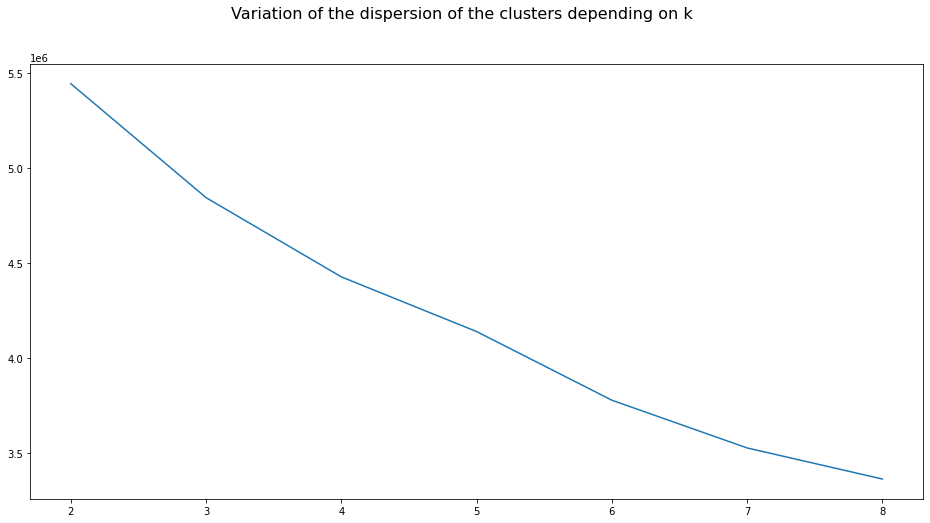

In [36]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Cluster dispersion")
fig.suptitle("Variation of the dispersion of the clusters depending on k", fontsize = 16);

We have two potentially good candidates, k=3 and k=5.  

In the case of k=3, we see that the SSE is still large enough and could be considerable lowered. Furthermore, since we have a significant large dataset, making only 3 cluster could not optimally differentiate clients, and consequently lose valuable information.  

For those reasons, we will select 5 clusters for our segmentation.

##### **k-means algortihm**

In [37]:
kmeans = KMeans(n_clusters=5, random_state=175)

kmeans.fit(df_standard)

cluster_labels = kmeans.labels_

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We add the clusters column to our dataset.

In [38]:
df_last_partition['cluster'] = cluster_labels
df_standard['cluster'] = cluster_labels

#### **4.3 Cluster interpretation**

In this section, we want to understand what our clusters are like. To do this, we are going to see the most relevant features, and what these features are like in each cluster.

First of all, que get a general vision of the most important stadistics of each feature depending in which cluster are they.

In [39]:
cluster_stats = df_last_partition.groupby('cluster').agg(['mean','median','std'])
cluster_stats

entry_channel                  active_customer                   \
                 mean median       std            mean median       std   
cluster                                                                   
0            2.376258    2.0  2.047771        0.976436    1.0  0.151689   
1            2.723116    2.0  1.745166        0.032199    0.0  0.176529   
2            1.798920    2.0  0.784909        0.352793    0.0  0.477840   
3            4.818009    5.0  0.930270        0.608995    1.0  0.487978   
4            1.915338    1.0  2.100891        0.995446    1.0  0.067336   

          segment                  region_code                      gender  \
             mean median       std        mean median        std      mean   
cluster                                                                      
0        1.841208    2.0  0.577929   26.501303   28.0  12.790511  0.557430   
1        1.435013    1.0  0.501692   25.168372   28.0  12.703911  0.497567   
2        1.199630    1.0  0.408784   25.650901   28.0  13.913127  0.453868   
3        1.429419    1.0  0.542834   26.869564   28.0  13.895610  0.504732   
4        1.907473    2.0  0.448517   26.047195   28.0  12.259388  0.607949   

                                age                           salary  \
        median       std       mean median        std           mean   
cluster                                                                
0          1.0  0.496698  39.603316   36.0  13.840812  119480.095710   
1          0.0  0.499996  30.677789   25.0  13.237828  127859.544132   
2          0.0  0.497869  28.150410   24.0   9.566023  110280.165132   
3          1.0  0.499980  30.720053   24.0  13.195516  113990.812238   
4          1.0  0.488259  42.080108   41.0  11.163049  129050.271524   

                                      total_products                   \
                median            std           mean median       std   
cluster                                                                 
0        109374.504692  208217.684388       2.819834    3.0  1.219379   
1        113399.904809  277262.110097       0.001050    0.0  0.032385   
2        101135.220000   98099.540785       1.082424    1.0  0.296903   
3        113399.904809   81657.512338       1.135149    1.0  0.391554   
4        109374.504692  201620.521307       3.887601    4.0  1.627021   

        account_prod                  financing_prod                   \
                mean median       std           mean median       std   
cluster                                                                 
0           2.163795    2.0  0.929861       0.000000    0.0  0.000000   
1           0.000411    0.0  0.020265       0.000000    0.0  0.000000   
2           1.078849    1.0  0.296280       0.000000    0.0  0.000000   
3           1.124677    1.0  0.392517       0.000000    0.0  0.000000   
4           2.347754    2.0  1.190349       1.004761    1.0  0.068842   

        saving_prod                      loyalty                     \
               mean median       std        mean median         std   
cluster                                                               
0          0.656039    1.0  0.546446  793.468236  767.0  409.516567   
1          0.000639    0.0  0.025272  666.075764  590.0  431.781880   
2          0.003574    0.0  0.059679  998.633226  981.0  303.615757   
3          0.010471    0.0  0.101792  292.419065  252.0  204.847854   
4          0.535086    0.0  0.607033  959.796729  984.0  411.011976   

        Registrations                  Cancellations                   \
                 mean median       std          mean median       std   
cluster                                                                 
0            4.055980    4.0  2.386877      3.126258    3.0  2.494545   
1            0.049472    0.0  0.298729      0.154459    0.0  0.529854   
2            0.159886    0.0  0.532800      0.159211    0.0  0.569559   
3            0.447077    0.0

We can draw our first conclusions:

* **Cluster 0 :** 
    * total_products : average of almost 3 products 
    * active_customers : ++
    * account_prod : big % of their products are account_prod
* **Cluster 1 :**  
    * active_customer : Non active customers
    * total_products : No products on their accounts
* **Cluster 2 :**   
    * age : less than 30 years old.
    * salary : low salary
    * loyalty : very loyalty to the company. Almost 3 years
* **Cluster 3 :** 
    * entry_channel : channel 5 with a little variance in the results
    * loyalty : new clients. Less than a year
* **Cluster 4 :**
    * gender : slightly more men than women (60%-40%)
    * age : +40 years old
    * salary : high salary
    * total_products : average of almost 4 products
    * financing_prod : only customers with financig_prod
    * total_revenue : ++revenue for the company
    * active_customer : ++

Now that we have drawn the first conclusions from our clusters, we are going to visualize certain features to see the relationship with the clusters more clearly.

**active_customer**    
We can see in this box plot how the cluster 0 and 4 are very active, and how the clients of cluster 1 are not active.

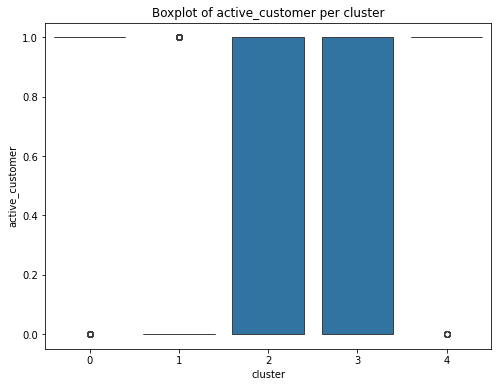

In [40]:
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster', y='active_customer', data=df_last_partition)
plt.title('Boxplot of active_customer per cluster')
plt.xlabel('cluster')
plt.ylabel('active_customer')
plt.show()

**entry_channel**    
We can confirm how the clients of cluster 3 has the entry_channel between 4 and 5. In fact, the mean are 4.8 and the median are 5, so we can assume that almost all the clients of this cluster has entry_channel = 5. Furthermore, the boxplot is very compact, so they are very close on this feature.

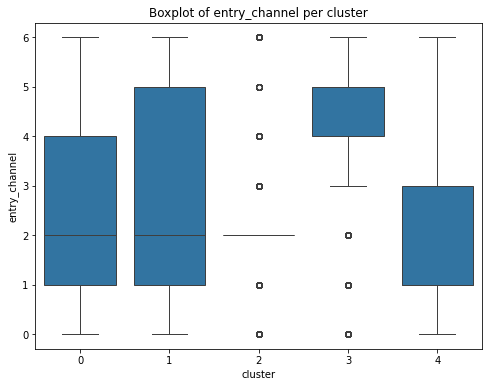

In [41]:
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster', y='entry_channel', data=df_last_partition)
plt.title('Boxplot of entry_channel per cluster')
plt.xlabel('cluster')
plt.ylabel('entry_channel')
plt.show()

**Age**   
We observe how the cluster 2 are the younger one. Furthermore, the boxplot of this feature are very compact, so indicate that all the clients of this cluster are very close on age. We also can apreciatte how the cluster 4 is the older one, with the biggest median.

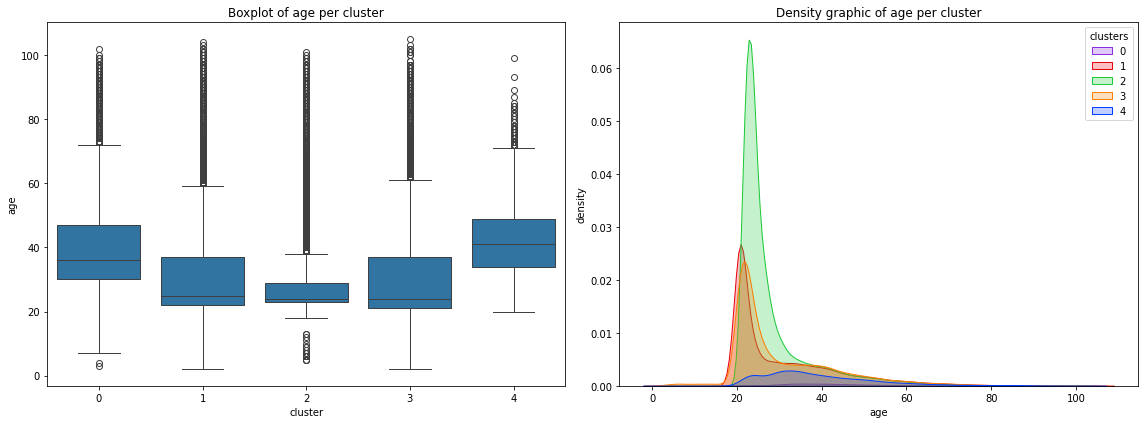

In [42]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

sns.boxplot(x='cluster', y='age', data=df_last_partition, ax = axs[0])
axs[0].set_title('Boxplot of age per cluster')
axs[0].set_xlabel('cluster')
axs[0].set_ylabel('age')

sns.kdeplot(data=df_last_partition, x='age', hue='cluster', palette='bright', fill = True, ax = axs[1])
axs[1].set_title(f'Density graphic of age per cluster')
axs[1].set_xlabel('age')
axs[1].set_ylabel('density')
axs[1].legend(title='clusters', labels=['0','1','2','3','4'])

plt.tight_layout()
plt.show()


**total_products**   
Cluster 0 and 4 have several products in his accounts, and cluster 1 have median of total_products equal to 0.

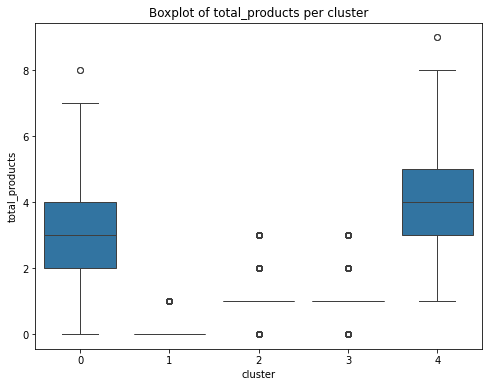

In [43]:
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster', y='total_products', data=df_last_partition)
plt.title('Boxplot of total_products per cluster')
plt.xlabel('cluster')
plt.ylabel('total_products')
plt.show()

**loyalty**   
We observe in both graphics how cluster 3 have very low loyalty. We see that they have less than 300 days in the company, and all the values are very compact, so it means that is a good characteristic for this cluster. In the other hand, we have that cluster 2 have high loyalty. We cans see in the second graphic how the values goes from 500 to 1500.

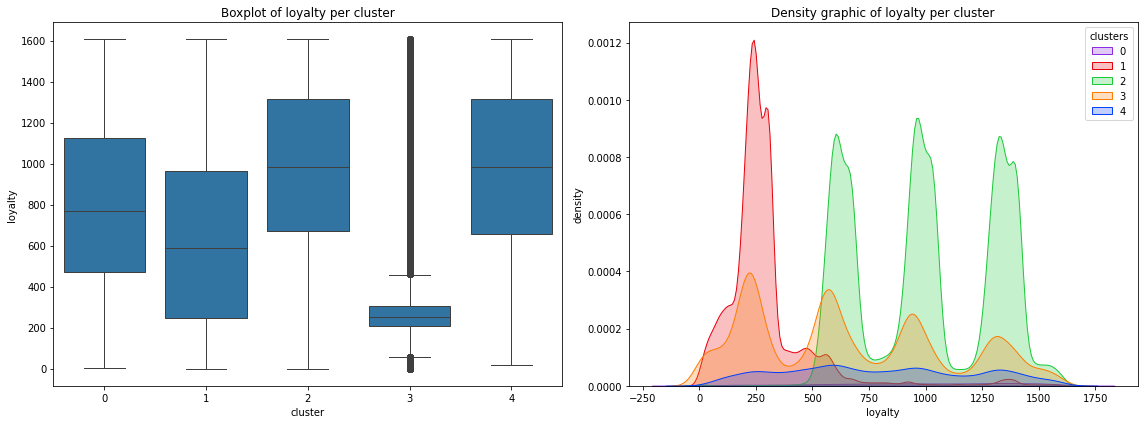

In [44]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

sns.boxplot(x='cluster', y='loyalty', data=df_last_partition, ax = axs[0])
axs[0].set_title('Boxplot of loyalty per cluster')
axs[0].set_xlabel('cluster')
axs[0].set_ylabel('loyalty')

sns.kdeplot(data=df_last_partition, x='loyalty', hue='cluster', palette='bright', fill = True, ax = axs[1])
axs[1].set_title(f'Density graphic of loyalty per cluster')
axs[1].set_xlabel('loyalty')
axs[1].set_ylabel('density')
axs[1].legend(title='clusters', labels=['0','1','2','3','4'])

plt.tight_layout()
plt.show()

#### **4.4 Client file**

The idea of this part is to make a file of the clients based on which cluster they belong to.To do this, we will categorize the clusters to understand in a better way what particularities each one has.

In [100]:
df_file = pd.DataFrame()

for i,col in enumerate(['gender','age', 'salary', 'entry_channel', 'active_customer', 'loyalty', 'total_products', 'account_prod', 'financing_prod']):
    data_resume = df_last_partition[['cluster',col]].groupby('cluster').describe().T[1:]
    df_file = pd.concat([ df_file, data_resume], axis = 0)

Generate our multiindex

In [101]:
out_index = [
    'Characteristics',
    'Characteristics',
    'Characteristics',
    'Characteristics',
    'Loyalty',
    'Loyalty',
    'Products',
    'Products',
    'Products'
]

inner_index = [
    'gender',
    'age',
    'salary',
    'entry_channel',
    'active_customer',
    'loyalty',
    'total_products',
    'account_prod',
    'financing_prod'
]

stadistics = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

new_multi_index = []

for oi,ii, in zip(out_index, inner_index):
    for es in stadistics:
        new_multi_index.append((oi, ii, es))

In [102]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [103]:
names = ["Indicators Group", "Indicator", "Statistical"]
file_index = generate_multiindex(new_multi_index, names)
df_file.set_index(file_index, inplace = True)

In [104]:
clusters_size = df_last_partition.groupby('cluster').size().to_frame().T
clusters_size.set_index(generate_multiindex([('General', 'Cluster', 'Size')], names), inplace = True)

In [105]:
df_file = pd.concat([clusters_size, df_file], axis = 0)

In [106]:
df_file = df_file.rename(columns = {
    0 : "Lot of products & active clients",
    1 : "Inactive clients",
    2 : "Younger & loyalty clients ",
    3 : "New clients",    
    4 : "VIP clients"
})


Finally we can see the table with the characteristics of each cluster in a very visual way

In [107]:
df_file.style.background_gradient(cmap = 'Blues', axis = 1)

#### **Cluster summary:**

**Cluster 0 : Active clients with a lot of products** 
* Size = **7.62%** 
* They are very active as a clients
* Have a lot of products --> almost 3 prod/client
* Usually are account products

**Cluster 1 : Inactive clients** 
* Size = **24.73%** 
* They have 0 activation as a clients
* Don't have anny product

**Cluster 2 : Younger and loyalty clients** 
* Size = **43.45%** 
* They are less than 30 years old (mean of 28, median of 24)
* Very loyalty to the company. Almost 3 years with us
* Low salaries
* 55% women

**Cluster 3 : New clients** 
* Size = **23.09%** 
* Less than 1 year with us
* They usually get into our company in the entry channel Number 5
* Only accounts products

**Cluster 4 : VIP clients** 
* Size = **1.09%** 
* 60% men
* +40 years old
* High salaries
* Lot of products --> only clients with financing products
* Very active as a clients and very loyalty to the company